<a href="https://colab.research.google.com/github/Rudi3601/CHC_Thesis/blob/main/lsv_deep_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%tensorflow_version 1.x

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
#import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
m = 10 # layer dimension
n = 2 # number of layers for local volatility
N = 20 # time discretization (should fit to maturities)
maturities = [0.5, 1.] # list of maturities in years

T = 1.0

layers = []
for j in range(len(maturities)):
    layersatT = []
    for i in range(n):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, activation='relu', trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]

#P = {(1.0,1.0): 0.4, (1.1,1.0):0.2, (0.9,1.0):0.5,
#     (1.0,0.5): 0.2, (1.1,0.5):0.1, (0.9,0.5):0.3}

P= {(0.9, 0.5): 0.20042534,
    (0.9, 1.0): 0.23559685,
    (1.0, 0.5): 0.16312157,
    (1.0, 1.0): 0.20771958,
    (1.1, 0.5): 0.13154241,
    (1.1, 1.0): 0.18236567}

hedges = {}
hedgeskey =[]
for key in P.keys():
    for j in range(N):
        hedge = Dense(nodes, activation='relu', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey
start = 0

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

normal = tf.distributions.Normal(loc=0., scale=1.)

def BS(x):
    price=x[0]
    vola=x[1]
    return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))
# increases computational time

for i in range(len(maturities)):
    for j in range(start,N):
        if maturities[i] >= j*T/N:
            helper0 = layers[i][0](price)
            for k in range(1,2):
                helper0 = layers[i][k](helper0) # local vol applied to price at time j*T/N
            BMincr = Input(shape=(1,)) # BM increment
            stochvol = Input(shape=(1,)) # stochvol value
            helper1 = Multiply()([helper0,BMincr])
            helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)
            priceincr = Multiply()([helper1,stochvol]) # new price increment
            for l in range(len(P.keys())):
                key = keylist[l]
                hedgeratio[key] = hedges[key][j](price)
                BSstrategy = Lambda(BS)([price,helper0])
                hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])
                hedge[key] = Multiply()([priceincr,hedgeratio[key]])
                hedgepf[l] = Add()([hedgepf[l],hedge[key]])
                if key[1]==((j+1)*T/N): # the option expires
                    helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(price)
                    helper2 = Subtract()([helper2,hedgepf[l]]) # payoff minus hedge
                    pricekey[l] = helper2
            price = Add()([price,priceincr]) #new price after one time step
            inputshelper = inputshelper + [stochvol]
            inputs = inputs + [BMincr]
        else:
            start = j
            break

inputs = inputs + inputshelper
pricekey = Concatenate()(pricekey)
localvol_trainhedge = Model(inputs=inputs, outputs=pricekey)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
<ipython-input-3-a0d2ebc90d3a>:15: RuntimeWarning: invalid value encountered in sqrt
  return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))


In [4]:
layers = []

for j in range(len(maturities)):
    layersatT = []
    for i in range(2):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, activation='relu', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]


hedges = {}
hedgeskey =[]
for key in P.keys():
    for j in range(N):
        hedge = Dense(nodes, activation='relu', trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey
start = 0

In [5]:
keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

for i in range(len(maturities)):
    for j in range(start,N):
        if maturities[i] >= j*T/N:
            layers[i][0].trainable=True
            helper0 = layers[i][0](price)
            for k in range(1,2):
                layers[i][k].trainable=True
                helper0 = layers[i][k](helper0)
            BMincr = Input(shape=(1,))
            stochvol = Input(shape=(1,))
            helper1 = Multiply()([helper0,BMincr])
            helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)
            priceincr = Multiply()([helper1,stochvol])
            for l in range(len(P.keys())):
                key = keylist[l]
                hedges[key][j].trainable=False
                hedgeratio[key] = hedges[key][j](price)
                BSstrategy = Lambda(BS)([price,helper0])
                hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])
                hedge[key] = Multiply()([priceincr,hedgeratio[key]])
                hedgepf[l] = Add()([hedgepf[l],hedge[key]])
                if key[1]==((j+1)*T/N):
                    helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(price)
                    helper2 = Subtract()([helper2,hedgepf[l]])
                    pricekey[l] = helper2
            price = Add()([price,priceincr])
            inputshelper = inputshelper + [stochvol]
            inputs = inputs + [BMincr]
        else:
            start = j
            break

inputs = inputs + inputshelper
pricekey = Concatenate()(pricekey)
localvol_trainlocvol = Model(inputs=inputs, outputs=pricekey)

<ipython-input-3-a0d2ebc90d3a>:15: RuntimeWarning: invalid value encountered in sqrt
  return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))


In [6]:
#localvol_trainlocvol.summary()

In [7]:
Ltrain = 5*10**3

xtrain =([np.ones(Ltrain)] + [np.zeros(Ltrain) for key in keylist]+
         [np.random.normal(0,1,Ltrain) for i in range(N)]+
         [np.ones(Ltrain) for i in range(N)])

ytrain=np.zeros((Ltrain,len(P.keys())))
for i in range(Ltrain):
    for l in range(len(P.keys())):
        key = keylist[l]
        ytrain[i,l]= P[key]

Train on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 6s 1ms/sample - loss: 0.0248
Epoch 2/15
5000/5000 [==============================] - 3s 610us/sample - loss: 0.0248
Epoch 3/15
5000/5000 [==============================] - 2s 404us/sample - loss: 0.0248
Epoch 4/15
5000/5000 [==============================] - 2s 397us/sample - loss: 0.0248
Epoch 5/15
5000/5000 [==============================] - 2s 404us/sample - loss: 0.0248
Epoch 6/15
5000/5000 [==============================] - 2s 396us/sample - loss: 0.0248
Epoch 7/15
5000/5000 [==============================] - 2s 412us/sample - loss: 0.0248
Epoch 8/15
5000/5000 [==============================] - 3s 583us/sample - loss: 0.0248
Epoch 9/15
5000/5000 [==============================] - 2s 384us/sample - loss: 0.0248
Epoch 10/15
5000/5000 [==============================] - 2s 381us/sample - loss: 0.0248
Epoch 11/15
5000/5000 [==============================] - 2s 396us/sample - loss: 0.0248
Epoch 12/15
5000/5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


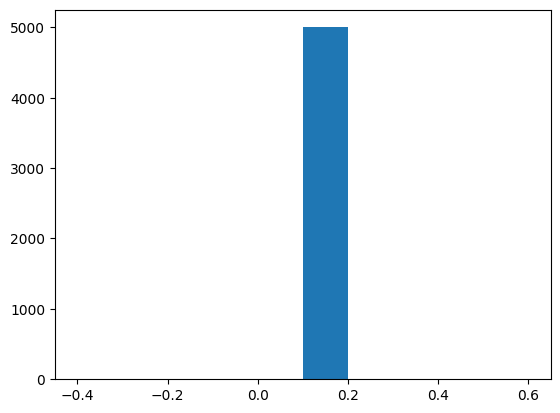

0.100000024
Train on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 4s 743us/sample - loss: 0.0248
Epoch 2/15
5000/5000 [==============================] - 2s 478us/sample - loss: 0.0248
Epoch 3/15
5000/5000 [==============================] - 2s 399us/sample - loss: 0.0248
Epoch 4/15
5000/5000 [==============================] - 2s 393us/sample - loss: 0.0248
Epoch 5/15
5000/5000 [==============================] - 2s 399us/sample - loss: 0.0248
Epoch 6/15
5000/5000 [==============================] - 3s 619us/sample - loss: 0.0248
Epoch 7/15
5000/5000 [==============================] - 2s 402us/sample - loss: 0.0248
Epoch 8/15
5000/5000 [==============================] - 2s 385us/sample - loss: 0.0248
Epoch 9/15
5000/5000 [==============================] - 2s 391us/sample - loss: 0.0248
Epoch 10/15
5000/5000 [==============================] - 2s 391us/sample - loss: 0.0248
Epoch 11/15
5000/5000 [==============================] - 2s 445us/sample - loss: 0.0248
Epoch 1

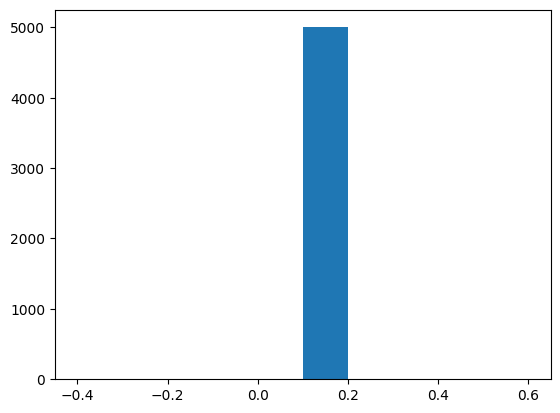

0.100000024
Train on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 2s 387us/sample - loss: 0.0248
Epoch 2/15
5000/5000 [==============================] - 3s 591us/sample - loss: 0.0248
Epoch 3/15
5000/5000 [==============================] - 2s 378us/sample - loss: 0.0248
Epoch 4/15
5000/5000 [==============================] - 2s 379us/sample - loss: 0.0248
Epoch 5/15
5000/5000 [==============================] - 2s 369us/sample - loss: 0.0248
Epoch 6/15
5000/5000 [==============================] - 2s 389us/sample - loss: 0.0248
Epoch 7/15
5000/5000 [==============================] - 2s 386us/sample - loss: 0.0248
Epoch 8/15
5000/5000 [==============================] - 3s 584us/sample - loss: 0.0248
Epoch 9/15
5000/5000 [==============================] - 2s 382us/sample - loss: 0.0248
Epoch 10/15
5000/5000 [==============================] - 2s 384us/sample - loss: 0.0248
Epoch 11/15
5000/5000 [==============================] - 2s 391us/sample - loss: 0.0248
Epoch 1

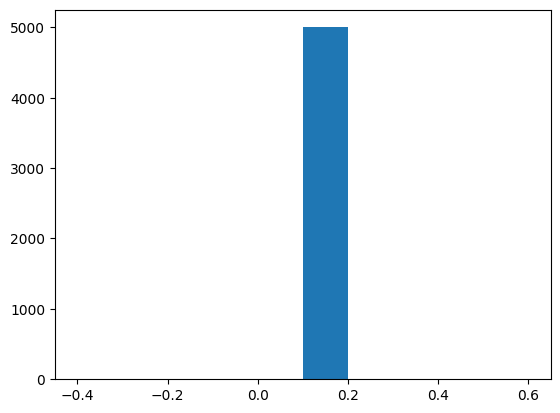

0.100000024


In [8]:
import matplotlib.pyplot as plt

localvol_trainhedge.compile(optimizer='adam',
              loss='mean_squared_error')
localvol_trainlocvol.compile(optimizer='adam',
              loss='mean_squared_error')
for i in range(3):
    localvol_trainhedge.fit(x=xtrain,y=ytrain, epochs=15,verbose=True)
    x = localvol_trainhedge.get_weights()
    localvol_trainlocvol.set_weights(x)
    localvol_trainlocvol.fit(x=xtrain,y=ytrain, epochs=5,verbose=True)
    plt.hist(localvol_trainhedge.predict(xtrain)[:,0])
    plt.show()
    print(np.mean(localvol_trainhedge.predict(xtrain)[:,0]))
    y = localvol_trainlocvol.get_weights()
    localvol_trainhedge.set_weights(y)

In [9]:
def custom_loss(y_true,y_pred):
    return K.mean((K.mean(y_pred,axis=0)-K.mean(y_true,axis=0))**2)

localvol_trainlocvol.compile(optimizer='adam',
              loss=custom_loss)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0248


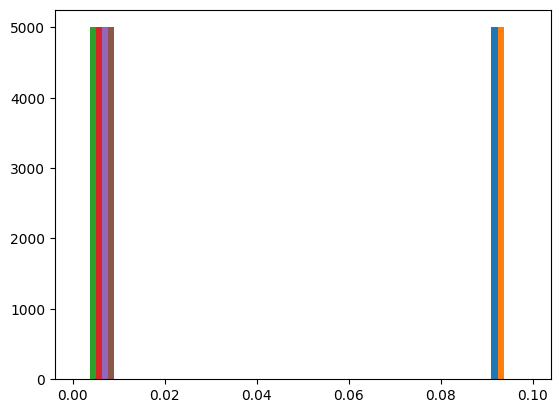

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248


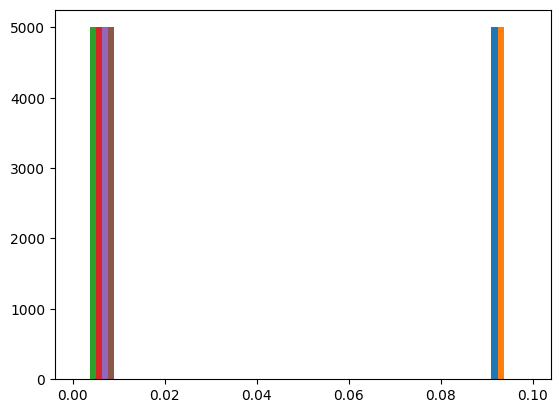

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248


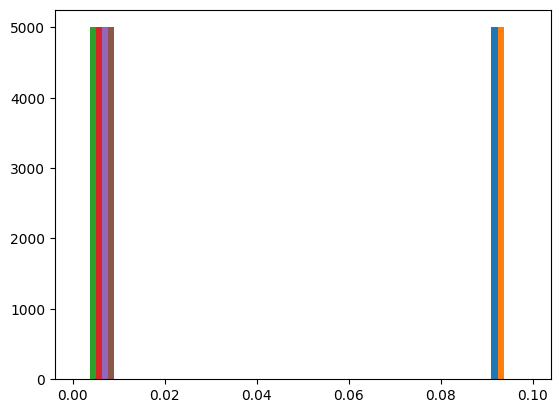

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 30us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248


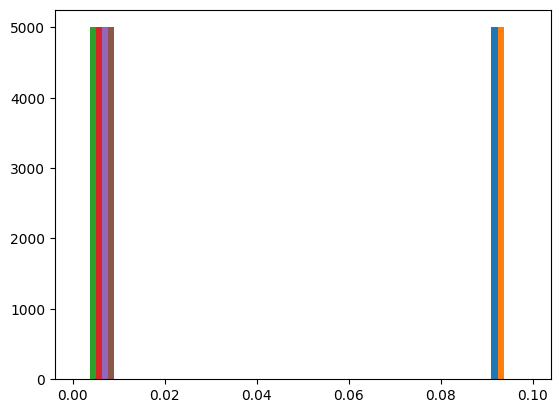

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 50us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 55us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 55us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 55us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 50us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 55us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 30us/sample - loss: 0.0248


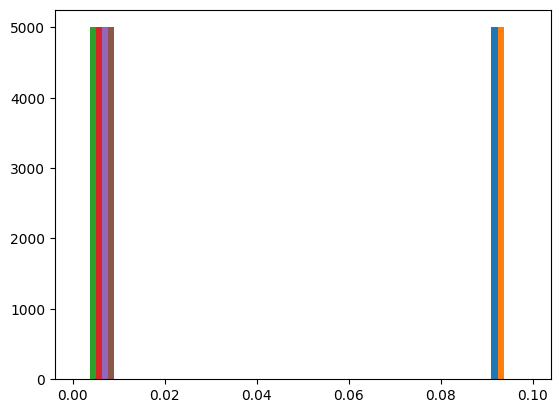

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 30us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248


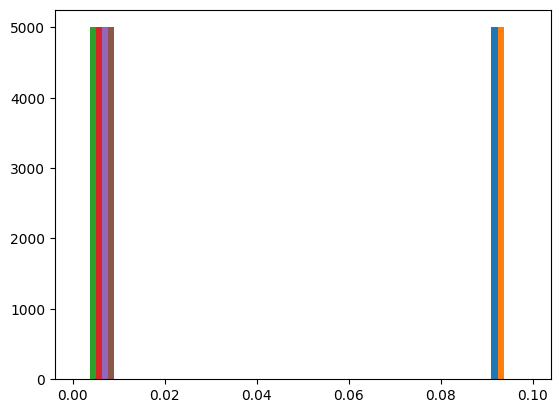

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 30us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248


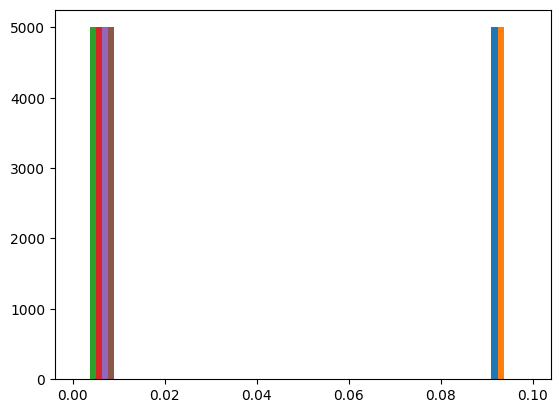

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 50us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 53us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 54us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 55us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 54us/sample - loss: 0.0248


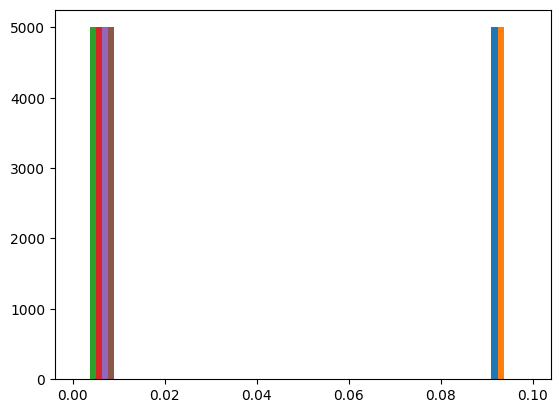

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0248


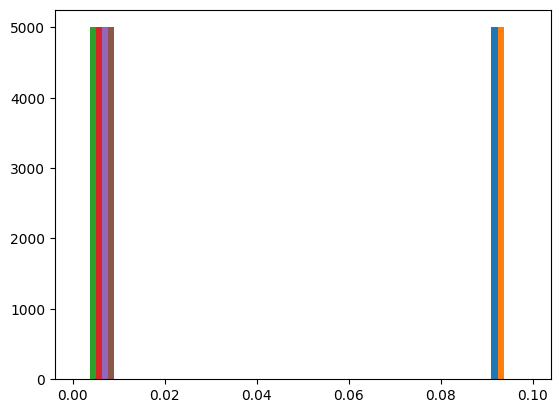

[0.10000426 0.10000426 0.         0.         0.         0.        ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 2/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 3/10
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0248
Epoch 4/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 5/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 6/10
5000/5000 [==============================] - 0s 32us/sample - loss: 0.0248
Epoch 7/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 8/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 9/10
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0248
Epoch 10/10
5000/5000 [==============================] - 0s 31us/sample - loss: 0.0248


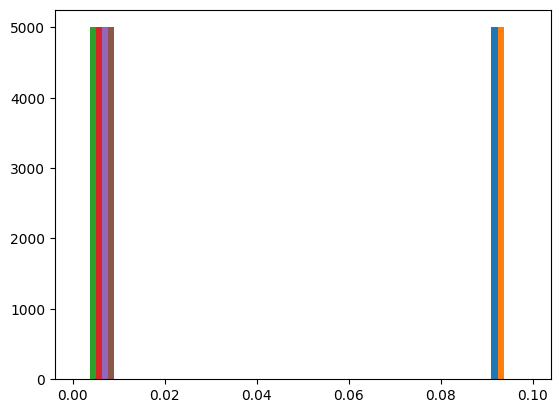

[0.10000426 0.10000426 0.         0.         0.         0.        ]


In [10]:
for i in range(10):
    localvol_trainlocvol.fit(x=xtrain,y=ytrain, epochs=10, verbose=True,batch_size=10**3)
    plt.hist(localvol_trainlocvol.predict(xtrain)[:,:])
    plt.show()
    print(np.mean(localvol_trainlocvol.predict(xtrain)[:,:],axis=0))

In [11]:
Ltest = 10**6

xtest =([np.ones(Ltest)] + [np.zeros(Ltest) for key in keylist]+
         [np.random.normal(0,1,Ltest) for i in range(N)]+
         [np.ones(Ltest) for i in range(N)])

ytest=np.zeros((Ltest,len(P.keys())))
for i in range(Ltest):
    for l in range(len(P.keys())):
        key = keylist[l]
        ytest[i,l]= P[key]

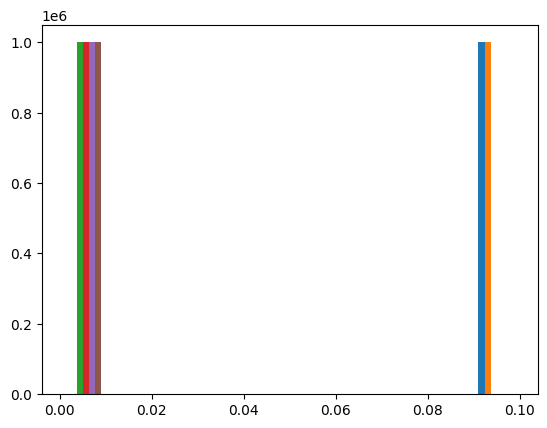

Calibrated values: [0.10095835 0.10095835 0.         0.         0.         0.        ]
Ground truth: [0.20042534, 0.23559685, 0.16312157, 0.20771958, 0.13154241, 0.18236567]


In [12]:
plt.hist(localvol_trainlocvol.predict(xtest)[:,:])
plt.show()
print('Calibrated values:', np.mean(localvol_trainlocvol.predict(xtest)[:,:],axis=0))
print('Ground truth:', [P[key] for key in keylist])

In [13]:
P

{(0.9, 0.5): 0.20042534,
 (0.9, 1.0): 0.23559685,
 (1.0, 0.5): 0.16312157,
 (1.0, 1.0): 0.20771958,
 (1.1, 0.5): 0.13154241,
 (1.1, 1.0): 0.18236567}

In [14]:
#maturities = [0.1, 0.25, 0.5, 1.0]
#strikes = [0.8, 0.9, 1.0, 1.1, 1.2]
#for T in maturities:
#    for K in strikes:
#         P[(K,T)] = 1.0
#Lgen = 10**6
#keylist = P.keys()
#xgen =([np.ones(Lgen)] + [np.zeros(Lgen) for key in keylist]+
#       [np.random.normal(0,1,Lgen) for i in range(N)]+
#       [np.ones(Lgen) for i in range(N)])
#
#ygen=np.mean(localvol_trainlocvol.predict(xgen)[:,:],axis=0)
#for l in range(len(P.keys())):
#    key = keylist[l]
#    P[key] = ygen[1,l]